In [1]:
import os

# 1. Create a directory for the data
if not os.path.exists('data'):
    os.makedirs('data')

# 2. Download the zip file (using a reliable mirror for the NASA dataset)
!#wget https://data.nasa.gov/docs/legacy/CMAPSSData.zip -O data/CMAPSSData.zip

# 3. Unzip it
#!unzip -o data/CMAPSSData.zip -d data/

#print("Data downloaded and extracted!")

In [95]:
# The dataset has 26 columns
# 1. Unit Number (Which engine is it?)
# 2. Time Cycles (How long has it been running?)
# 3-5. Operational Settings (Altitude, Speed, etc.)
# 6-26. Sensor Readings (s1 to s21)

index_names = ['unit_nr', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i) for i in range(1, 22)] 
col_names = index_names + setting_names + sensor_names

print(col_names)

['unit_nr', 'time_cycles', 'setting_1', 'setting_2', 'setting_3', 's_1', 's_2', 's_3', 's_4', 's_5', 's_6', 's_7', 's_8', 's_9', 's_10', 's_11', 's_12', 's_13', 's_14', 's_15', 's_16', 's_17', 's_18', 's_19', 's_20', 's_21']


In [3]:
import pandas as pd

data_df = pd.read_csv('data/train_FD001.txt', sep=r'\s+', header=None, names=col_names)

print("Training data shape:", data_df.shape)
data_df.head()

Training data shape: (20631, 26)


,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [ ]:
def load_fd(fd_tag):
    train_path = f"data/train_{fd_tag}.txt"
    test_path  = f"data/test_{fd_tag}.txt"
    rul_path   = f"data/RUL_{fd_tag}.txt"

    train_df = pd.read_csv(train_path, sep=r'\s+', header=None, names=col_names)
    test_df  = pd.read_csv(test_path,  sep=r'\s+', header=None, names=col_names)

    # train labels: compute RUL from run-to-failure
    max_cycle = train_df.groupby('unit_nr')['time_cycles'].max().rename('max_cycle')
    train_df = train_df.merge(max_cycle, left_on='unit_nr', right_index=True)
    train_df['RUL'] = train_df['max_cycle'] - train_df['time_cycles']

    # test labels: provided separately
    rul_labels = pd.read_csv(rul_path, header=None, names=['RUL_truth'])
    return train_df, test_df, rul_labels



FDFD001 - Train shape: (20631, 28), Test shape: (13096, 26), RUL labels shape: (100, 1)
FDFD002 - Train shape: (53759, 28), Test shape: (33991, 26), RUL labels shape: (259, 1)
FDFD003 - Train shape: (24720, 28), Test shape: (16596, 26), RUL labels shape: (100, 1)
FDFD004 - Train shape: (61249, 28), Test shape: (41214, 26), RUL labels shape: (248, 1)


In [127]:
next_unit = 1
train_dfs = []

data_tags = ["FD001","FD002","FD003","FD004"]
#data_tags = ["FD004"]


for fd_tag in data_tags:
    train_df, test_df, rul_labels = load_fd(fd_tag)
    train_df['fd'] = fd_tag

    # make a mapping for this FD's units
    uniq_units = sorted(train_df['unit_nr'].unique())
    mapping = {u: next_unit + i for i, u in enumerate(uniq_units)}
    next_unit += len(uniq_units)

    train_df = train_df.assign(
        unit_nr_orig=train_df['unit_nr'],
        unit_nr=train_df['unit_nr'].map(mapping),
        fd=fd_tag
    )
    train_dfs.append(train_df)

data_df = pd.concat(train_dfs, ignore_index=True)


In [128]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160359 entries, 0 to 160358
Data columns (total 30 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   unit_nr       160359 non-null  int64  
 1   time_cycles   160359 non-null  int64  
 2   setting_1     160359 non-null  float64
 3   setting_2     160359 non-null  float64
 4   setting_3     160359 non-null  float64
 5   s_1           160359 non-null  float64
 6   s_2           160359 non-null  float64
 7   s_3           160359 non-null  float64
 8   s_4           160359 non-null  float64
 9   s_5           160359 non-null  float64
 10  s_6           160359 non-null  float64
 11  s_7           160359 non-null  float64
 12  s_8           160359 non-null  float64
 13  s_9           160359 non-null  float64
 14  s_10          160359 non-null  float64
 15  s_11          160359 non-null  float64
 16  s_12          160359 non-null  float64
 17  s_13          160359 non-null  float64
 18  s_14

In [129]:
from sklearn.preprocessing import MinMaxScaler


not_scaled_cols = ['unit_nr', 'RUL', 'max_cycle']

col_set = set(col_names)
columns_to_scale = [col for col in col_names if col not in not_scaled_cols]

print("Columns to scale:", columns_to_scale)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(data_df[columns_to_scale])
scaled_data_df = pd.DataFrame(scaled, columns=columns_to_scale, index=data_df.index)

scaled_data_df.insert(0, 'unit_nr', data_df['unit_nr'])
scaled_data_df.insert(len(scaled_data_df.columns), 'RUL', data_df['RUL'])
scaled_data_df.insert(len(scaled_data_df.columns), 'max_cycle', data_df['max_cycle'])
scaled_data_df.head()


Columns to scale: ['time_cycles', 'setting_1', 'setting_2', 'setting_3', 's_1', 's_2', 's_3', 's_4', 's_5', 's_6', 's_7', 's_8', 's_9', 's_10', 's_11', 's_12', 's_13', 's_14', 's_15', 's_16', 's_17', 's_18', 's_19', 's_20', 's_21']


,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,RUL,max_cycle
0,1,0.000000,0.000190,0.000237,1.0,1.0,0.969990,0.927293,0.902111,1.0,...,0.653748,0.090428,1.0,0.918367,1.0,1.0,0.972082,0.970373,191,192
1,1,0.001845,0.000252,0.000356,1.0,1.0,0.973000,0.932957,0.908192,1.0,...,0.637831,0.094654,1.0,0.918367,1.0,1.0,0.970064,0.970630,190,192
2,1,0.003690,0.000105,0.001068,1.0,1.0,0.974824,0.922723,0.910730,1.0,...,0.641715,0.089844,1.0,0.897959,1.0,1.0,0.968382,0.966204,189,192
3,1,0.005535,0.000224,0.000712,1.0,1.0,0.974824,0.908829,0.905152,1.0,...,0.643055,0.072803,1.0,0.918367,1.0,1.0,0.966028,0.967860,188,192
4,1,0.007380,0.000162,0.000475,1.0,1.0,0.975007,0.908989,0.915565,1.0,...,0.642988,0.093829,1.0,0.928571,1.0,1.0,0.966700,0.969560,187,192


In [130]:
import numpy as np

sequence_length = 50

def create_sequences(data, targets, seq_length=50):
    sequences = []
    target_list = []
    for i in range(len(data) - seq_length + 1):
        seq = data[i:i + seq_length]
        target = targets[i + seq_length - 1]
        sequences.append(seq)
        target_list.append(target)
    return np.array(sequences), np.array(target_list)


In [131]:
engine_ids = scaled_data_df['unit_nr'].unique()
engine_ids

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [133]:
train_ids = engine_ids[:650]
test_ids = engine_ids[650:]
print("len train ids:", len(train_ids))
print("len test ids:", len(test_ids))
print("len engine ids:", len(engine_ids))

len train ids: 650
len test ids: 59
len engine ids: 709


In [134]:
train_df = scaled_data_df[scaled_data_df['unit_nr'].isin(train_ids)]
test_df = scaled_data_df[scaled_data_df['unit_nr'].isin(test_ids)]
print("Train df shape:", train_df.shape)
print("Test df shape:", test_df.shape)

train_df.head()

Train df shape: (146510, 28)
Test df shape: (13849, 28)


,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,RUL,max_cycle
0,1,0.000000,0.000190,0.000237,1.0,1.0,0.969990,0.927293,0.902111,1.0,...,0.653748,0.090428,1.0,0.918367,1.0,1.0,0.972082,0.970373,191,192
1,1,0.001845,0.000252,0.000356,1.0,1.0,0.973000,0.932957,0.908192,1.0,...,0.637831,0.094654,1.0,0.918367,1.0,1.0,0.970064,0.970630,190,192
2,1,0.003690,0.000105,0.001068,1.0,1.0,0.974824,0.922723,0.910730,1.0,...,0.641715,0.089844,1.0,0.897959,1.0,1.0,0.968382,0.966204,189,192
3,1,0.005535,0.000224,0.000712,1.0,1.0,0.974824,0.908829,0.905152,1.0,...,0.643055,0.072803,1.0,0.918367,1.0,1.0,0.966028,0.967860,188,192
4,1,0.007380,0.000162,0.000475,1.0,1.0,0.975007,0.908989,0.915565,1.0,...,0.642988,0.093829,1.0,0.928571,1.0,1.0,0.966700,0.969560,187,192


In [135]:
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view

def create_sequences_vectorized(X, y, unit_ids, seq_length=50):
    # 1. Create windows (Batch, Seq, Features)
    X_windows = sliding_window_view(X, window_shape=seq_length, axis=0)
    X_windows = X_windows.transpose(0, 2, 1) # (Batch, Seq, Features)
    
    # 2. Align Targets (End of window)
    y_aligned = y[seq_length-1:]
    
    # 3. Create Mask (Ensure window doesn't cross units)
    unit_ids_start = unit_ids[:-seq_length+1]
    unit_ids_end   = unit_ids[seq_length-1:]
    valid_mask = (unit_ids_start == unit_ids_end)
    
    return X_windows[valid_mask], y_aligned[valid_mask]

# --- Usage ---
sensor_cols = [c for c in train_df.columns if c.startswith('s_')]




# 1. Prepare arrays (Sorted)
train_df = train_df.sort_values(['unit_nr', 'time_cycles'])
test_df = test_df.sort_values(['unit_nr', 'time_cycles'])


# Apply rolling mean with window 9 (common for FD001)
#print("Smoothing sensor data...")
for col in sensor_cols:
    train_df[col] = train_df.groupby('unit_nr')[col].transform(
    lambda x: x.rolling(window=9, min_periods=1).mean())
    test_df[col] = test_df.groupby('unit_nr')[col].transform(
    lambda x: x.rolling(window=9, min_periods=1).mean())


# 2. CRITICAL: Drop Target (RUL) and max_cycle from Inputs
# We only want the 24 sensor/setting columns + time_cycle
features_to_drop = ['unit_nr', 'RUL', 'max_cycle', "s_1", "s_5", "s_10", "s_16", "s_18", "s_19"]

X_train_arr = train_df.drop(columns=features_to_drop).values
y_train_arr = train_df['RUL'].values 
train_units = train_df['unit_nr'].values

X_test_arr = test_df.drop(columns=features_to_drop).values
y_test_arr = test_df['RUL'].values
test_units = test_df['unit_nr'].values

# 3. Create Sequences
X_train_seq, y_train_seq = create_sequences_vectorized(X_train_arr, y_train_arr, train_units, 50)
X_test_seq, y_test_seq = create_sequences_vectorized(X_test_arr, y_test_arr, test_units, 50)

print(f"Train Input Shape: {X_train_seq.shape}") 
# Expected shape: (N, 50, 24) -> 24 features

import torch


X_train_tensor = torch.tensor(X_train_seq, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_seq, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test_seq, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_seq, dtype=torch.float32)   

print(f"X_train_tensor.shape: {X_train_tensor.shape}")
print(f"y_train_tensor.shape: {y_train_tensor.shape}")

print(f"X_test_tensor.shape: {X_test_tensor.shape}")
print(f"y_test_tensor.shape: {y_test_tensor.shape}")
print(f"X_test_tensor[0]: {X_test_tensor[0]}")
print(f"y_test_tensor[0]: {y_test_tensor[0]}")

Train Input Shape: (114660, 50, 19)
X_train_tensor.shape: torch.Size([114660, 50, 19])
y_train_tensor.shape: torch.Size([114660])
X_test_tensor.shape: torch.Size([10958, 50, 19])
y_test_tensor.shape: torch.Size([10958])
X_test_tensor[0]: tensor([[0.0000e+00, 8.3334e-01, 9.9858e-01, 1.0000e+00, 1.7878e-01, 3.1448e-01,
         2.3734e-01, 1.4555e-01, 1.3446e-01, 6.5032e-01, 2.8912e-01, 4.3875e-01,
         1.3266e-01, 9.9322e-01, 4.9616e-01, 3.9634e-01, 3.1633e-01, 1.6044e-01,
         1.6130e-01],
        [1.8450e-03, 2.3828e-01, 2.9860e-01, 1.0000e+00, 4.0386e-01, 5.0518e-01,
         4.4770e-01, 3.8018e-01, 3.6457e-01, 7.5150e-01, 4.5769e-01, 5.8167e-01,
         3.6431e-01, 9.9313e-01, 5.6513e-01, 2.7577e-01, 4.8980e-01, 3.9236e-01,
         3.9487e-01],
        [3.6900e-03, 4.7632e-01, 8.3147e-01, 1.0000e+00, 4.8621e-01, 5.4334e-01,
         4.7779e-01, 4.1991e-01, 3.9524e-01, 7.8878e-01, 4.9915e-01, 6.0208e-01,
         3.9527e-01, 9.9312e-01, 5.3765e-01, 2.9898e-01, 5.3741e-01, 4

In [142]:
from torch.utils.data import DataLoader, TensorDataset
from torch import nn
from sklearn.metrics import mean_squared_error
import copy

# 1. Add Dropout to the Model
class EngineRULPredictor(nn.Module):
    def __init__(self, input_size, hidden_size=256, num_layers=2, dropout=0.2):
        super().__init__()
        # Dropout only works if num_layers > 1
        self.lstm = nn.LSTM(
            input_size, 
            hidden_size, 
            num_layers=num_layers, 
            batch_first=True,
            dropout=dropout
        )
        #self.fc = nn.Linear(hidden_size, 1)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        out, _ = self.lstm(x)
        last_out = out[:, -1, :]
        return self.fc(last_out)

# 2. Setup (Reduced hidden size slightly to 128 to prevent overfitting)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


model = EngineRULPredictor(input_size=X_train_tensor.shape[2], hidden_size=512, num_layers=2, dropout=0.2)
model = model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5
)

# 3. Training with "Save Best" logic
EPOCHS = 150  # Lower epochs, let early stopping do the work
best_test_rmse = float('inf')
best_model_wts = copy.deepcopy(model.state_dict())
max_rul = train_df['RUL'].max()

y_train_tensor = torch.tensor(y_train_seq / max_rul, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_seq / max_rul, dtype=torch.float32)

# Move validation data to GPU once
X_test_gpu = X_test_tensor.to(device)
y_test_real = y_test_seq # Keep real values for RMSE calculation


train_loader = DataLoader(
    TensorDataset(X_train_tensor, y_train_tensor),
    batch_size=256,
    shuffle=True,
    drop_last=True
)


print("Starting Training with Validation...")

for epoch in range(EPOCHS):
    model.train() # Set to training mode (enables Dropout)
    epoch_loss = 0
    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        out = model(X_batch)
        loss = criterion(out.squeeze(), y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        
    # --- Validation Step ---
    model.eval() # Set to eval mode (disables Dropout)
    with torch.no_grad():
        # Get predictions
        preds_scaled = model(X_test_gpu).cpu().numpy().flatten()
        # Unscale
        preds_real = preds_scaled * max_rul
        # Calculate true RMSE
        mse = mean_squared_error(y_test_real, preds_real)
        current_rmse = np.sqrt(mse)
        scheduler.step(current_rmse)
    
    # Save model if it's the best so far
    if current_rmse < best_test_rmse:
        best_test_rmse = current_rmse
        best_model_wts = copy.deepcopy(model.state_dict())
        print(f"Epoch {epoch+1}: New Best RMSE: {current_rmse:.2f}")
    
    if (epoch + 1) % 10 == 0:
        avg_train_loss = epoch_loss / len(train_loader)
        print(f"Epoch {epoch+1}: Train Loss {avg_train_loss:.6f} | Test RMSE {current_rmse:.2f}")

# 4. Load the best weights back
print(f"Training complete. Best RMSE: {best_test_rmse:.2f}")
model.load_state_dict(best_model_wts)

Using device: cuda
Starting Training with Validation...
Epoch 1: New Best RMSE: 74.14
Epoch 2: New Best RMSE: 47.83
Epoch 8: New Best RMSE: 47.48
Epoch 10: New Best RMSE: 47.00
Epoch 10: Train Loss 0.007928 | Test RMSE 47.00
Epoch 13: New Best RMSE: 46.73
Epoch 14: New Best RMSE: 46.68
Epoch 15: New Best RMSE: 46.60
Epoch 17: New Best RMSE: 46.42
Epoch 20: New Best RMSE: 46.36
Epoch 20: Train Loss 0.007269 | Test RMSE 46.36
Epoch 22: New Best RMSE: 46.24
Epoch 23: New Best RMSE: 45.96
Epoch 25: New Best RMSE: 45.67
Epoch 28: New Best RMSE: 45.31
Epoch 30: Train Loss 0.007662 | Test RMSE 47.71
Epoch 35: New Best RMSE: 44.78
Epoch 38: New Best RMSE: 44.60
Epoch 39: New Best RMSE: 44.16
Epoch 40: Train Loss 0.006587 | Test RMSE 44.34
Epoch 42: New Best RMSE: 43.54
Epoch 44: New Best RMSE: 43.07
Epoch 46: New Best RMSE: 42.71
Epoch 47: New Best RMSE: 42.34
Epoch 50: Train Loss 0.006321 | Test RMSE 42.70
Epoch 52: New Best RMSE: 41.97
Epoch 55: New Best RMSE: 41.91
Epoch 56: New Best RMSE: 

<All keys matched successfully>

Test RMSE: 40.69


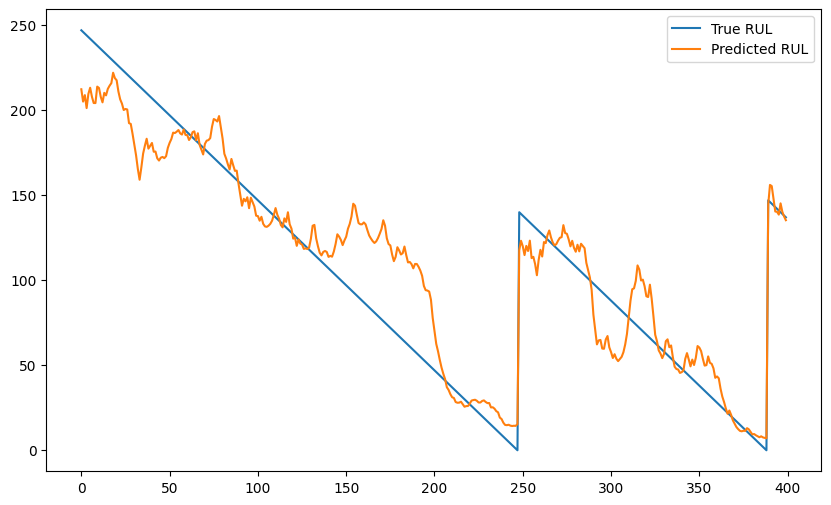

In [144]:
X_test_tensor = X_test_tensor.to("cpu")
y_test_tensor = y_test_tensor.to("cpu")
model.to("cpu")

#X_test_tensor = torch.tensor(X_test_seq, dtype=torch.float32).to(device)
# y_test_seq is the original TRUE RUL (not scaled)

model.eval()
with torch.no_grad():
    # Predict (Output is 0-1)
    preds_scaled = model(X_test_tensor)
    # Un-scale (Output becomes 0-300)
    preds_real = preds_scaled.cpu().numpy().flatten() * max_rul

# Calculate RMSE on real values
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test_seq, preds_real)
print(f"Test RMSE: {np.sqrt(mse):.2f}")

from matplotlib import pyplot as plt

# Plot
plt.figure(figsize=(10,6))
plt.plot(y_test_seq[:400], label='True RUL')
plt.plot(preds_real[:400], label='Predicted RUL')
plt.legend()
plt.show()

In [ ]:
import torch
print(f'Torch version: {torch.__version__}')
print(f'CUDA available: {torch.cuda.is_available()}')
print(f'CUDA device count: {torch.cuda.device_count()}')
if torch.cuda.is_available():
    print(f'Active device: {torch.cuda.get_device_name(torch.cuda.current_device())}')
else:
    print('No CUDA devices detected.')

In [ ]:
import torch
if not torch.cuda.is_available():
    raise SystemExit('CUDA is not available; skipping tensor test.')
device = torch.device('cuda')
x = torch.randn(1000, 1000, device=device)
y = torch.randn(1000, 1000, device=device)
z = torch.matmul(x, y)
print(f'Result tensor device: {z.device}')
print(f'Result sample: {z.flatten()[0].item():.6f}')